In [2]:
from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c eeg-data-classification
!mkdir eeg-data-classification
!unzip /content/eeg-data-classification.zip -d eeg-data-classification

  0% 0.00/906k [00:00<?, ?B/s]
100% 906k/906k [00:00<00:00, 101MB/s]
Archive:  /content/eeg-data-classification.zip
  inflating: eeg-data-classification/Sample_submission.csv  
  inflating: eeg-data-classification/test.csv  
  inflating: eeg-data-classification/train.csv  


## Overview

In [6]:
!pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.9/109.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 58.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flask to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.4 MB/s eta 0:00:00
  Preparing me

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/eeg-data-classification/train.csv', index_col='id')
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,Class
id,,,,,,,,,,,,,,,,,
0,0.292428,0.293124,0.314311,0.358699,0.331543,0.225766,0.239241,0.272733,0.286617,0.288724,0.396327,0.369219,0.454737,0.401026,NaN,0.373793,0
1,0.227376,0.371844,0.281638,0.296169,0.165798,0.183871,0.279604,0.508437,0.417472,0.404794,0.117159,0.366740,0.339934,0.513000,0.451442,0.463053,1
2,0.630380,0.355120,0.373488,0.266282,0.339572,0.080644,0.164020,0.225593,0.152664,0.250015,0.744645,0.347192,0.353192,0.359334,0.408117,0.447714,1
3,0.892770,0.385269,NaN,NaN,0.339572,0.338680,0.325313,0.548815,0.264808,0.395856,0.239452,0.410747,0.452542,0.403616,0.457993,0.457478,1
4,0.430202,0.107202,0.463268,0.114090,0.235297,0.167705,0.260785,0.239052,0.174473,0.193488,0.275656,0.173596,0.278163,0.153616,0.286076,0.225951,0


In [5]:
df['Class'].value_counts()

,count
Class,
0,4127
1,3361


In [12]:
df_prep = pd.DataFrame(columns=df.columns)
for label in df['Class'].unique():
    filtered_df = df[df['Class'] == label]
    df_prep = pd.concat([df_prep, filtered_df.sample(3000)], axis=0)

df_prep['Class'].value_counts()

<ipython-input-12-9622cd80d83a>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_prep = pd.concat([df_prep, filtered_df.sample(3000)], axis=0)


,count
Class,
0,3000
1,3000


## Model Selection

In [32]:
from pycaret.classification import *
import torch

clf_setup = setup(df, target='Class', session_id=42, use_gpu=torch.cuda.is_available())
best_model = compare_models(sort='Accuracy', include=['dt', 'rf', 'xgboost', 'catboost'])
best_model = create_model(best_model)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(7488, 17)"
4,Transformed data shape,"(7488, 17)"
5,Transformed train set shape,"(5241, 17)"
6,Transformed test set shape,"(2247, 17)"
7,Numeric features,16
8,Rows with missing values,56.5%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8767,0.9504,0.8321,0.8866,0.8582,0.7494,0.7509,6.4510
xgboost,Extreme Gradient Boosting,0.8750,0.9481,0.8440,0.8738,0.8583,0.7466,0.7473,0.2480
rf,Random Forest Classifier,0.8674,0.9431,0.8125,0.8833,0.8461,0.7300,0.7323,1.6200
dt,Decision Tree Classifier,0.7615,0.7581,0.7249,0.7393,0.7318,0.5171,0.5175,0.7790


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pycaret/internal/pycaret_experiment/supervised_experiment.py:339: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_cols, subset=["TT (Sec)"])


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8648,0.9484,0.8051,0.8837,0.8426,0.7245,0.7269
1,0.8664,0.9430,0.8170,0.8767,0.8458,0.7282,0.7296
2,0.8855,0.9546,0.8426,0.8959,0.8684,0.7672,0.7684
3,0.8779,0.9478,0.8596,0.8670,0.8632,0.7529,0.7529
4,0.8664,0.9496,0.7915,0.8986,0.8416,0.7269,0.7313
5,0.8702,0.9482,0.8511,0.8584,0.8547,0.7375,0.7375
6,0.8721,0.9463,0.8085,0.8962,0.8501,0.7391,0.7421
7,0.9103,0.9654,0.8809,0.9159,0.8980,0.8180,0.8185
8,0.8798,0.9435,0.8298,0.8945,0.8609,0.7553,0.7570


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Prediction

In [34]:
test_df = pd.read_csv('/content/eeg-data-classification/test.csv', index_col='id')
test_df.drop(columns='Class', inplace=True)
test_df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
id,,,,,,,,,,,,,,,,
0,0.817868,0.319941,0.377547,0.372264,0.360949,0.212870,0.276878,0.319874,0.423668,0.339272,0.083986,0.347192,0.443717,0.460898,NaN,0.418423
1,0.130386,0.350090,0.540831,0.364104,0.425130,NaN,0.104838,0.393933,0.146407,0.217283,0.450890,0.354534,0.304636,0.437487,NaN,0.400283
2,0.679447,0.269672,0.348973,0.353240,0.270073,0.161288,0.284950,0.195325,0.289715,0.264871,0.404879,0.281158,0.386294,0.390615,0.409448,0.386331
3,0.034554,0.366846,0.504099,0.353240,0.296767,0.283827,0.325313,0.612829,0.323978,0.357147,0.293370,0.378993,0.529809,0.424487,0.451442,0.428187
4,0.934683,0.262976,0.328598,NaN,0.248644,0.219350,0.279604,0.289607,0.199380,0.244037,0.093934,0.273863,0.269295,0.315103,0.345139,0.347276


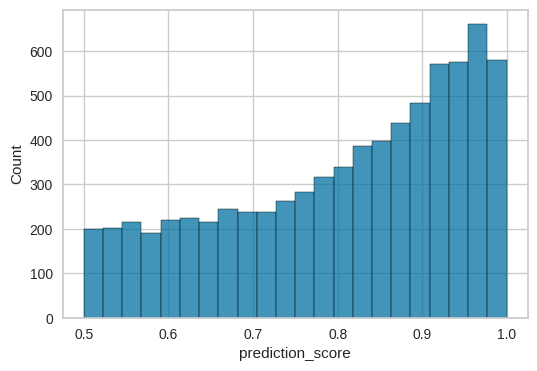

In [35]:
y_pred = predict_model(best_model, data=test_df)

plt.figure(figsize=(6, 4))
sns.histplot(y_pred['prediction_score'])
plt.show()

In [37]:
submission = pd.read_csv('/content/eeg-data-classification/Sample_submission.csv')
submission.loc[3:, 'Class'] = y_pred.loc[3:, 'prediction_label']
submission.head()

,id,Class
0,0,0.0
1,1,0.0
2,2,1.0
3,3,1.0
4,4,0.0


In [38]:
submission['Class'].value_counts()

,count
Class,
0.0,4376
1.0,3112


In [40]:
submission.to_csv('catboost_2.csv', index=False)